In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [2]:
!pip install -q keras==2.3.0

     |████████████████████████████████| 378kB 3.5MB/s 


In [3]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.0


In [0]:
import numpy as np
from time import time
from keras.applications import mobilenet_v2
from keras.applications import vgg16
from keras.preprocessing import image as kimage
from keras.models import Model, load_model
from keras.layers import Dense, Dropout
from keras import optimizers
train_preprocessing = kimage.ImageDataGenerator(preprocessing_function = mobilenet_v2.preprocess_input)
train_preprocessing2 = kimage.ImageDataGenerator(preprocessing_function = vgg16.preprocess_input)

In [5]:
t0 = time()
!wget https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar

--2020-02-11 10:25:04--  https://www.dropbox.com/s/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar [following]
--2020-02-11 10:25:04--  https://www.dropbox.com/s/raw/drwy7fq5svwv78p/101_ObjectCategories_split.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaad89f4e3dca254243c9830739.dl.dropboxusercontent.com/cd/0/inline/Ax665wKFPkE2FD6Vlr0rqfbRlDK6n8o5NzOMUmebRB_yNFVXnpRuvh0oVdtmf-n_G_95Qb9TiNgmEC6QQ31Bt0Xt9JCXRVYi0CY79mYKbJcF7g/file# [following]
--2020-02-11 10:25:05--  https://ucaad89f4e3dca254243c9830739.dl.dropboxusercontent.com/cd/0/inline/Ax665wKFPkE2FD6Vlr0rqfbRlDK6n8o5NzOMUmebRB_yNFVXnpRuvh0oVdtmf-n_G_95Qb9TiNgmEC6QQ

In [0]:
import tarfile
tar = tarfile.open('101_ObjectCategories_split.tar')
tar.extractall()
tar.close()

In [7]:
!rm 101_ObjectCategories_split.tar
print("Trasferimento file completato in %0.3f secondi" % (time() - t0))

Trasferimento file completato in 9.301 secondi


In [0]:
base_path = '101_ObjectCategories_split/'

# Fine Tuning prima rete neurale (MobileNet_v2)

## Data loader
Un data loader si occupa di gestire i seguenti aspetti:<br>


*   Caricare dati di input, e target
*   Dividere il dataset in minibatch
*   Applicare trasformazioni di preprocessing e data augmentation


###Training set


Definisco le trasformazioni da appicare (pre-elaborare le nostre immagini con la stessa procedura impiegata durante il suo addestramento originale, tramite mobilenet_v2.preprocess_input)

In [9]:
train_processing = kimage.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
train_generator = train_processing.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1
)

Found 4600 images belonging to 102 classes.


Con shuffle=True  è possibile ridistribuire le immagini in ordine casuale negli esempi di addestramento, è fondamentale per assicurarsi che in ciascun minibatch siano presenti esempi da tutte le classi (o più classi possibili)



###Test set

In [10]:
test_processing = kimage.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 4544 images belonging to 102 classes.


##Rete Neurale

Carico mobile_net (MobileNetV2 pre-addestrata):


*   weights specifica su quale dataset deve essere stata pre-addestrata.
*   include_top indica se ci interessa importare anche il layer fully-connected finale (che mappa alla cardinalità del problema originale).
*   pooling specifica se e come aggregare le feature estratte per ogni data immagine






In [11]:
base_net = mobilenet_v2.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

9412608/9406464 [==============================] - 0s 0us/step


Info sul modello:

In [12]:
len(base_net.layers)

156

Visualizzazione tabellare

In [13]:
from keras.utils import print_summary
print_summary(base_net)
Alias: base_net.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Visualizzazione grafica:

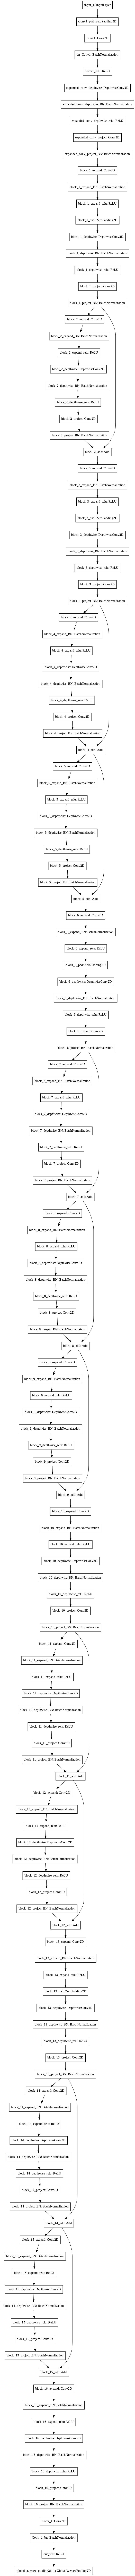

In [14]:
from keras.utils import plot_model
plot_model(base_net, to_file='model.png')

## Specializzazione della rete
Si decide di mantenere fissi i pesi relativi alla rete imagenet, mentre sarà possibile effettuare training di tutti i layer aggiuntivi

In [0]:
for layer in base_net.layers:
  layer.trainable = False

Aggiunta di strati:<br>Costruiamo un'estensione temporanea della rete di base, aggiungendo un primo fully-connected che mappi a 1024 dimensioni, una ReLU, ed un ultimo fully-connected che mappi al problema di interesse (102 classi).



In [0]:
# Output del modello di base
x = base_net.output
# Nuovo livello fully-connected intermedio + ReLU
x = Dense(1024, activation='relu')(x)
# Nuovo livello fully-connected finale + softmax
pred = Dense(102, activation='softmax')(x)

Incapsuliamo il tutto in un nuovo modello, chiamato net, che abbia la seguente interfaccia:<br>


*   input: lo stesso input della rete di base
*   output: l'output dell'estensione temporanea appena definita

In [0]:
net = Model(inputs = base_net.input, outputs = pred)

##Fine Tuning

In [0]:
net.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics=["accuracy"])

In [19]:
net.fit_generator(train_generator, epochs=5, validation_data = test_generator)

Epoch 1/5
144/144 [==============================] - 35s 243ms/step - loss: 1.5624 - accuracy: 0.6580 - val_loss: 0.9410 - val_accuracy: 0.8110
Epoch 2/5
144/144 [==============================] - 24s 166ms/step - loss: 0.4025 - accuracy: 0.8820 - val_loss: 0.7471 - val_accuracy: 0.8261
Epoch 3/5
144/144 [==============================] - 24s 168ms/step - loss: 0.2172 - accuracy: 0.9315 - val_loss: 0.5638 - val_accuracy: 0.8332
Epoch 4/5
144/144 [==============================] - 24s 163ms/step - loss: 0.1511 - accuracy: 0.9520 - val_loss: 1.5838 - val_accuracy: 0.8096
Epoch 5/5
144/144 [==============================] - 23s 161ms/step - loss: 0.1173 - accuracy: 0.9624 - val_loss: 1.1343 - val_accuracy: 0.8389


Valutazione del modello:

In [0]:
validation = net.evaluate_generator(test_generator)

In [21]:
print("Il modello sul Test Set raggiunge una Accuracy pari a: " + str(validation[1]) + "\n" + "La Loss raggiunta è: " + str(validation[0]))

Il modello sul Test Set raggiunge una Accuracy pari a: 0.8389084339141846
La Loss raggiunta è: 1.13427734375


Si osserva che i valori di Loss registrati in fase di validation dal modello sono elevati rispetto a quelli registrati in fase di training, probabilmente è necessario fornire più epoche al modello per eliminare l'overfitting o cambiare la struttura del modello inserendo Dropout e Batch Normalization.
<br>Per effettuare un confronto con tutti i modelli in tempi accettabili si decide di eseguire il training dei dati su 5 epoche diverse per ogni modello e non modificare la struttura della rete

##Data Loader

Si implementano due diverse configurazioni di train_preprocessing e train_generator per valutare l'impatto sui risultati forniti dalla rete:

In [22]:
train_processing6 = kimage.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input, height_shift_range=0.25, horizontal_flip=True, rotation_range = 90)
train_generator6 = train_processing6.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


In [23]:
train_processing7 = kimage.ImageDataGenerator(preprocessing_function=mobilenet_v2.preprocess_input, height_shift_range=0.25, width_shift_range=[-100, 100], horizontal_flip=True, vertical_flip=True, rotation_range=90, zoom_range=[0.5,1.0])
train_generator7 = train_processing7.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


Si immplementano test_preprocessing e test_generator per la nuova rete:

##Fine Tuning

#### Versione con Data Augmentation (train_generator6):


*   height_shift_range=0.25
*   horizontal_flip=True
*   rotation_range = 90



In [0]:
net = Model(inputs = base_net.input, outputs = pred)

In [25]:
net.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics=["accuracy"])
net.fit_generator(train_generator6, epochs=5, validation_data = test_generator)

Epoch 1/5
144/144 [==============================] - 74s 511ms/step - loss: 1.1644 - accuracy: 0.7248 - val_loss: 1.0966 - val_accuracy: 0.8338
Epoch 2/5
144/144 [==============================] - 71s 495ms/step - loss: 0.8053 - accuracy: 0.7839 - val_loss: 0.4070 - val_accuracy: 0.8402
Epoch 3/5
144/144 [==============================] - 69s 479ms/step - loss: 0.7039 - accuracy: 0.8048 - val_loss: 0.9847 - val_accuracy: 0.8611
Epoch 4/5
144/144 [==============================] - 69s 477ms/step - loss: 0.6434 - accuracy: 0.8222 - val_loss: 0.4420 - val_accuracy: 0.8572
Epoch 5/5
144/144 [==============================] - 69s 482ms/step - loss: 0.5518 - accuracy: 0.8446 - val_loss: 0.7086 - val_accuracy: 0.8380


Valutazione del modello:

In [0]:
validation6 = net.evaluate_generator(test_generator)

In [27]:
print("Il modello sul Test Set raggiunge una Accuracy pari a: " + str(validation6[1]) + "\n" + "La Loss raggiunta è: " + str(validation6[0]))

Il modello sul Test Set raggiunge una Accuracy pari a: 0.8380281925201416
La Loss raggiunta è: 0.3903713524341583


Si osserva che in fase di training il modello non overfitta come nel caso precedente, raggiunge in fase di test un valore di accuracy simile a quello ottenuto dal modello precedente, con una Loss però decisamente ridotta a confronto

#### Versione con Data Augmentation  (train_generator7):


*   height_shift_range=0.25
*   horizontal_flip=True
*   rotation_range = 90
*   width_shift_range=[-100, 100]
*   vertical_flip=True
*   zoom_range=[0.5,1.0]



In [0]:
net = Model(inputs = base_net.input, outputs = pred)

In [29]:
net.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics=["accuracy"])
net.fit_generator(train_generator7, epochs=5, validation_data = test_generator)

Epoch 1/5
144/144 [==============================] - 77s 536ms/step - loss: 2.6374 - accuracy: 0.4022 - val_loss: 0.5644 - val_accuracy: 0.7995
Epoch 2/5
144/144 [==============================] - 70s 485ms/step - loss: 2.3360 - accuracy: 0.4441 - val_loss: 0.7380 - val_accuracy: 0.7755
Epoch 3/5
144/144 [==============================] - 68s 473ms/step - loss: 2.2610 - accuracy: 0.4663 - val_loss: 0.5381 - val_accuracy: 0.7947
Epoch 4/5
144/144 [==============================] - 66s 459ms/step - loss: 2.1833 - accuracy: 0.4798 - val_loss: 1.1160 - val_accuracy: 0.7491
Epoch 5/5
144/144 [==============================] - 66s 458ms/step - loss: 2.1509 - accuracy: 0.4811 - val_loss: 0.9243 - val_accuracy: 0.7190


Valutazione del modello:

In [0]:
validation7 = net.evaluate_generator(test_generator)

In [31]:
print("Il modello sul Test Set raggiunge una Accuracy pari a: " + str(validation7[1]) + "\n" + "La Loss raggiunta è: " + str(validation7[0]))

Il modello sul Test Set raggiunge una Accuracy pari a: 0.7189700603485107
La Loss raggiunta è: 0.8722988963127136


Si osserva che il modello in fase di training raggiunge valori altissimi di Loss, che risultano più bassi in fase di validation. Nella fase di valutazione il valore di Accuracy raggiunto è decisamente più basso rispetto ai modelli precedenti, la sua loss invece è più alta.
<br>Probabilmente è stata applicata una augmentation dei dati molto pretenziosa ed esagerata che il modello non riesce a classificare correttamente.

#Fine Tuning seconda rete neurale (VGG16)
Si decide di implementare una rete con architettura VGG16 ed implementare data augmentation

##Data Loader

Si immplementano tre diverse configurazioni di train_preprocessing e train_generator per la nuova rete:

In [32]:
train_processing2 = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
train_generator2 = train_processing2.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


In [33]:
train_processing3 = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, height_shift_range=0.25, horizontal_flip=True, rotation_range = 90)
train_generator3 = train_processing3.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


In [34]:
train_processing4 = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, height_shift_range=0.25, width_shift_range=[-100, 100], horizontal_flip=True, vertical_flip=True, rotation_range=90, zoom_range=[0.5,1.0])
train_generator4 = train_processing4.flow_from_directory(
        directory=base_path+'train',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
        seed=1)

Found 4600 images belonging to 102 classes.


Si immplementano test_preprocessing e test_generator per la nuova rete:

In [35]:
test_processing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)
test_generator = test_processing.flow_from_directory(
        directory=base_path+'test',
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 4544 images belonging to 102 classes.


##Rete Neurale

Carico mobile_net (VGG16 pre-addestrata):

In [36]:
vgg = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

58892288/58889256 [==============================] - 1s 0us/step


Info sul modello:

In [37]:
len(vgg.layers)

20

Visualizzazione tabellare

In [38]:
from keras.utils import print_summary
print_summary(vgg)
Alias: vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Visualizzazione grafica:

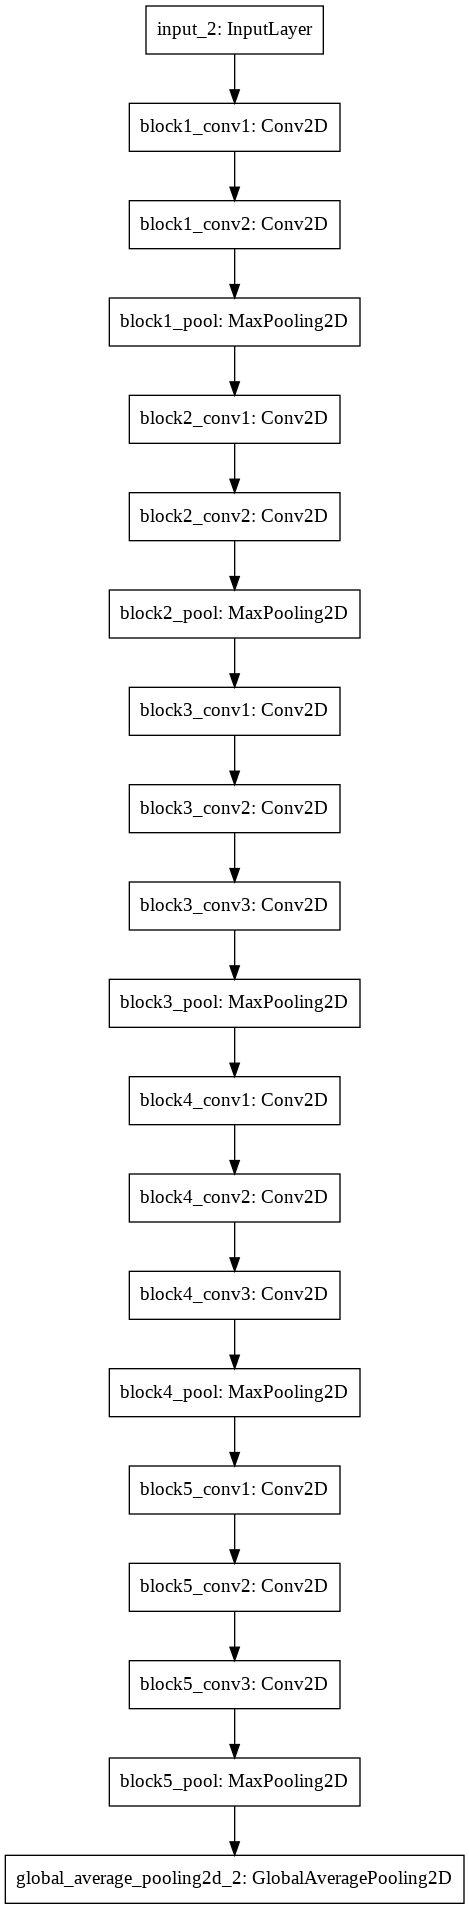

In [39]:
from keras.utils import plot_model
plot_model(vgg, to_file='model.png')

## Specializzazione della rete
Si decide di mantenere fissi i pesi relativi alla rete VGG congelandoli, si effettua il training solo dei layer successivamente aggiunti

In [0]:
for layer in vgg.layers:
  layer.trainable = False

Aggiunta di strati:<br> Anche per questa rete si implementano delle modifiche aggiungendo un'estensione identica al modello precedente: si aggiunge un layer fully-connected da 1024 neuroni con funzione di attivazione ReLU ed un layer fully connected con 10 neuroni e funzione di attivazione softmax che sappia classificare le istanze del dataset.

In [0]:
# Output del modello di base
x = vgg.output
# Nuovo livello fully-connected intermedio + ReLU
x = Dense(1024, activation='relu')(x)
# Nuovo livello fully-connected finale + softmax
pred = Dense(102, activation='softmax')(x)

Si definisce un nuovo modello per applicare la modifica

In [0]:
net2 = Model(inputs = vgg.input, outputs = pred)

##Fine Tuning

####Versione senza Data Augmentation (train_generator2)

In [0]:
net2 = Model(inputs = vgg.input, outputs = pred)

In [44]:
net2.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics=["accuracy"])
net2.fit_generator(train_generator2, epochs=5, validation_data = test_generator)

Epoch 1/5
144/144 [==============================] - 52s 360ms/step - loss: 1.9014 - accuracy: 0.6930 - val_loss: 0.5506 - val_accuracy: 0.8030
Epoch 2/5
144/144 [==============================] - 46s 321ms/step - loss: 0.3673 - accuracy: 0.9128 - val_loss: 0.4559 - val_accuracy: 0.8400
Epoch 3/5
144/144 [==============================] - 46s 320ms/step - loss: 0.2267 - accuracy: 0.9478 - val_loss: 0.7462 - val_accuracy: 0.8191
Epoch 4/5
144/144 [==============================] - 46s 321ms/step - loss: 0.1858 - accuracy: 0.9654 - val_loss: 1.4113 - val_accuracy: 0.8530
Epoch 5/5
144/144 [==============================] - 46s 320ms/step - loss: 0.1205 - accuracy: 0.9746 - val_loss: 0.6359 - val_accuracy: 0.8636


Valutazione del modello:

In [0]:
validation2 = net2.evaluate_generator(test_generator)

In [46]:
print("Il modello sul Test Set raggiunge una Accuracy pari a: " + str(validation2[1]) + "\n" + "La Loss raggiunta è: " + str(validation2[0]))

Il modello sul Test Set raggiunge una Accuracy pari a: 0.8635563254356384
La Loss raggiunta è: 1.5580880641937256


Il modello implementato con VGG senza augmentation fornisce una accuracy superiore a quella del modello mobile_net, purtroppo la Loss raggiunta è altrettanto elevata. Si nota infatti che in fase di training si verifica il fenomeno di overfitting.
<br>Anche in questo caso probabilmente il modello dovrebbe avere più epoche a disposizione per apprendere dai dati

#### Versione con Data Augmentation (train_generator3):


*   height_shift_range=0.25
*   horizontal_flip=True
*   rotation_range = 90



In [0]:
net2 = Model(inputs = vgg.input, outputs = pred)

In [48]:
net2.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics=["accuracy"])
net2.fit_generator(train_generator3, epochs=5, validation_data = test_generator)

Epoch 1/5
144/144 [==============================] - 81s 564ms/step - loss: 1.1243 - accuracy: 0.7750 - val_loss: 0.3810 - val_accuracy: 0.8543
Epoch 2/5
144/144 [==============================] - 77s 532ms/step - loss: 0.6194 - accuracy: 0.8500 - val_loss: 2.5139 - val_accuracy: 0.8431
Epoch 3/5
144/144 [==============================] - 77s 534ms/step - loss: 0.4864 - accuracy: 0.8802 - val_loss: 0.9975 - val_accuracy: 0.8633
Epoch 4/5
144/144 [==============================] - 76s 531ms/step - loss: 0.4497 - accuracy: 0.8952 - val_loss: 0.3674 - val_accuracy: 0.8482
Epoch 5/5
144/144 [==============================] - 77s 532ms/step - loss: 0.3787 - accuracy: 0.9078 - val_loss: 1.6316 - val_accuracy: 0.8391


Valutazione del modello:

In [0]:
validation3 = net2.evaluate_generator(test_generator)

In [50]:
print("Il modello sul Test Set raggiunge una Accuracy pari a: " + str(validation3[1]) + "\n" + "La Loss raggiunta è: " + str(validation3[0]))

Il modello sul Test Set raggiunge una Accuracy pari a: 0.8391284942626953
La Loss raggiunta è: 0.058165207505226135


Anche in questo caso si osserva una forte presenza di Overfitting, il valore di accuracy restituito è sufficientemente alto, ma inferiore rispetto al modello vgg senza overfitting.
<br> A differenza dei modelli precedenti il valore di loss registrato è molto basso

#### Versione con Data Augmentation  (train_generator4):


*   height_shift_range=0.25
*   horizontal_flip=True
*   rotation_range = 90
*   width_shift_range=[-100, 100]
*   vertical_flip=True
*   zoom_range=[0.5,1.0]



In [0]:
net2 = Model(inputs = vgg.input, outputs = pred)

In [52]:
net2.compile(loss = keras.losses.categorical_crossentropy, optimizer = keras.optimizers.RMSprop(), metrics=["accuracy"])
net2.fit_generator(train_generator4, epochs=5, validation_data = test_generator)

Epoch 1/5
144/144 [==============================] - 82s 572ms/step - loss: 1.7724 - accuracy: 0.6017 - val_loss: 1.8109 - val_accuracy: 0.8471
Epoch 2/5
144/144 [==============================] - 78s 541ms/step - loss: 1.4870 - accuracy: 0.6337 - val_loss: 1.8675 - val_accuracy: 0.8565
Epoch 3/5
144/144 [==============================] - 77s 533ms/step - loss: 1.3910 - accuracy: 0.6589 - val_loss: 0.6007 - val_accuracy: 0.8424
Epoch 4/5
144/144 [==============================] - 77s 531ms/step - loss: 1.2796 - accuracy: 0.6826 - val_loss: 1.4742 - val_accuracy: 0.8479
Epoch 5/5
144/144 [==============================] - 77s 538ms/step - loss: 1.2558 - accuracy: 0.6915 - val_loss: 1.0889 - val_accuracy: 0.8446


Valutazione del modello:

In [0]:
validation4 = net2.evaluate_generator(test_generator)

In [54]:
print("Il modello sul Test Set raggiunge una Accuracy pari a: " + str(validation4[1]) + "\n" + "La Loss raggiunta è: " + str(validation4[0]))

Il modello sul Test Set raggiunge una Accuracy pari a: 0.8446303009986877
La Loss raggiunta è: 0.6668766736984253


Durante la fase di training il modello possiede una loss molto elevata, si verifica anche in fase di validation ma i valori risultano comunque vicini tra loro.
<br> La accuracy che viene raggiunta è simile a quella dei modelli precedenti, il valore di loss è più elevato del penultimo modello.
<br> Anche in questo caso si dovrebbe testare il modello concedendo più epoche per effettuare training, probabilmente però come per la tipologia di rete precedente l'augmentation effettuata richiede uno sforzo maggiore alla rete che non riesce a classificare correttamente tutte le immagini.